(bayesian_workflow)=

# The Bayesian Workflow

:::{post} Jun 16, 2025
:tags: workflow
:category: intermediate, how-to
:author: Thomas Wiecki, Chris Fonnesbeck
:::

Bayesian inference is a powerful tool for extracting inference from data using probability models. This involves an interplay among statistical models, subject matter knowledge, and computational techniques. In building Bayesian models, it is easy to get carried away with complex models from the outset, often leading to an unsatisfactory final result (or a dead end). To avoid common model development pitfalls, a structured approach is helpful. The *Bayesian workflow* (Gelman *et al.*) is a systematic approach to building, validating, and refining probabilistic models, ensuring that the models are robust, interpretable, and useful for decision-making. The workflow's iterative nature ensures that modeling assumptions are tested and refined as the model grows, leading to more reliable results.

This workflow is particularly powerful in high-level probabilistic programming environments like PyMC, where the ability to rapidly prototype and iterate on complex statistical models enables practitioners to focus on the modeling process rather than the underlying computational details. The workflow invlolves moving from simple models--via prior checks, fitting, diagnostics, and refinement--through to a final product that satisfies the analytic goals, making sure that computational and conceptual issues are identified and addressed systematically as they are encountered.

Below we demonstrate the Bayesian workflow using COVID-19 case data, showing how to progress from very basic, unrealistic models to more sophisticated formulations, highlighting the critical role of model checking and validation at each step. Here we are not looking to develop a state-of-the-art epidemiological model, but rather to demonstrate how to iterate from a simple model to a more complex one.

In [1]:
import warnings

import arviz as az
import load_covid_data
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import polars as pl
import preliz as pz
import pymc as pm

from plotly.subplots import make_subplots

warnings.simplefilter("ignore")

RANDOM_SEED = 8451997
sampler_kwargs = {"chains": 4, "cores": 4, "tune": 2000, "random_seed": RANDOM_SEED}

Bayesian methods offer several fundamental strengths that make it particularly valuable for building robust statistical models. Its great **flexibility** allows practitioners to build remarkably complex models from simple building blocks. The framework provides a principled way of dealing with **uncertainty**, capturing not just the most likely outcome but the complete distribution of all possible outcomes. Critically, Bayesian methods allow **expert information** to guide model development through the use of informative priors, incorporating domain knowledge directly into the analysis.

In this section you'll learn:
* How to go from data to a model idea
* How to find priors for your model
* How to evaluate a model
* How to iteratively improve a model
* How to forecast into the future
* How powerful generative modeling can be

## Load data

First we'll load data on COVID-19 cases from the World Health Organization (WHO). In order simplify the analysis we will restrict the dataset to the time after 100 cases were confirmed (as reporting is often very noisy prior to that). It also allows us to align countries with each other for easier comparison.

In [2]:
df = load_covid_data.load_data(drop_states=True, filter_n_days_100=2)
countries = df.select("country").unique().to_series().to_list()
n_countries = len(countries)
df = df.filter(pl.col("days_since_100") >= 0)
df.head()

country,state,date,confirmed,type,critical_estimate,days_since_100,deaths
str,str,date,i64,str,f64,i64,i64
"""Diamond Princess""",null,2020-02-10,135,"""confirmed""",6.75,0,0
"""Diamond Princess""",null,2020-02-11,135,"""confirmed""",6.75,1,0
"""Diamond Princess""",null,2020-02-12,175,"""confirmed""",8.75,2,0
"""Diamond Princess""",null,2020-02-13,175,"""confirmed""",8.75,3,0
"""Diamond Princess""",null,2020-02-14,218,"""confirmed""",10.9,4,0


## Bayesian Workflow

Next, we will start developing a model of the spread. These models will start out simple (and poor) but we will iteratively improve them. A good workflow to adopt when developing your own models is:

1. Plot the data
2. Build model
3. Run prior predictive check
4. Fit model
5. Assess convergence
6. Check model fit
7. Improve model

### 1. Plot the data

We will look at German COVID-19 cases. At first, we will only look at the first 30 days after Germany crossed 100 cases, later we will look at the full data.

In [3]:
from datetime import datetime

country = "Germany"
date = datetime.strptime("2020-07-31", "%Y-%m-%d").date()
df_country = df.filter(pl.col("country") == country).filter(pl.col("date") <= date).head(30)

fig = px.line(
    df_country.to_pandas(),
    x="days_since_100",
    y="confirmed",
    title=f"{country} - COVID-19 Cases",
    labels={"days_since_100": "Days since 100 cases", "confirmed": "Confirmed cases"},
)
fig.show()

Look at the above plot and think of what type of model you would build to model the data.

### 2. Build model

The above line kind of looks exponential. This matches with knowledge from epidemiology whereas early in an epidemic it grows exponentially.

In [4]:
# Get time-range of days since 100 cases were crossed
t = df_country.select("days_since_100").to_numpy().flatten()
# Get number of confirmed cases for Germany
confirmed = df_country.select("confirmed").to_numpy().flatten()

with pm.Model() as model_exp1:
    # Intercept
    a = pm.Normal("a", mu=0, sigma=100)

    # Slope
    b = pm.Normal("b", mu=0.3, sigma=0.3)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Error term
    eps = pm.HalfNormal("eps", 100)

    # Likelihood
    pm.Normal("obs", mu=growth, sigma=eps, observed=confirmed)

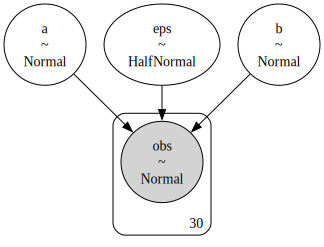

In [5]:
pm.model_to_graphviz(model_exp1)

Just looking at the above model, what do you think? Is there anything you would have done differently?

## 3. Run prior predictive check

Without even fitting the model to our data, we generate new potential data from our priors. Usually we have less intuition about the parameter space, where we define our priors, and more intution about what data we might expect to see. A prior predictive check thus allows us to make sure the model can generate the types of data we expect to see.

The process works as follows:

1. Pick a point from the prior $\theta_i$
2. Generate data set $x_i \sim f(\theta_i)$ where $f$ is our likelihood function (e.g. normal).
3. Rinse and repeat $n$ times.

In [6]:
with model_exp1:
    prior_pred = pm.sample_prior_predictive()

Sampling: [a, b, eps, obs]


In [7]:
prior_obs = prior_pred.prior_predictive["obs"].values.squeeze().T

fig = go.Figure()
for i in range(min(100, prior_obs.shape[1])):  # Show max 100 traces
    fig.add_trace(
        go.Scatter(
            x=list(range(len(prior_obs[:, i]))),
            y=prior_obs[:, i],
            mode="lines",
            line=dict(color="steelblue", width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.update_layout(
    title="Prior predictive",
    xaxis_title="Days since 100 cases",
    yaxis_title="Positive cases",
    yaxis=dict(range=[-1000, 1000]),
    xaxis=dict(range=[0, 10]),
)
fig.show()

Does this look sensible? Why or why not? What is the prior predictive sample telling us?

### What's wrong with this model?

Above you hopefully identified a few issues with this model:
1. Cases can't be negative
2. Cases can not start at 0, as we set it to start at above 100.
3. Case counts can't go down

Let's improve our model. The presence of negative cases is due to us using a Normal likelihood. Instead, let's use a `NegativeBinomial`, which is similar to `Poisson` which is commonly used for count-data but has an extra dispersion parameter that allows more flexiblity in modeling the variance of the data.

We will also change the prior of the intercept to be centered at 100 and tighten the prior of the slope.

The negative binomial distribution uses an overdispersion parameter, which we will describe using a gamma distribution. A companion package called `preliz`, a library for prior distribution elicitation, has a nice utility called `maxent` that will help us parameterize this prior, as the gamma distribution is not as intuitive to work with as the normal distribution.

(Gamma(alpha=2.22, beta=0.255), <Axes: >)

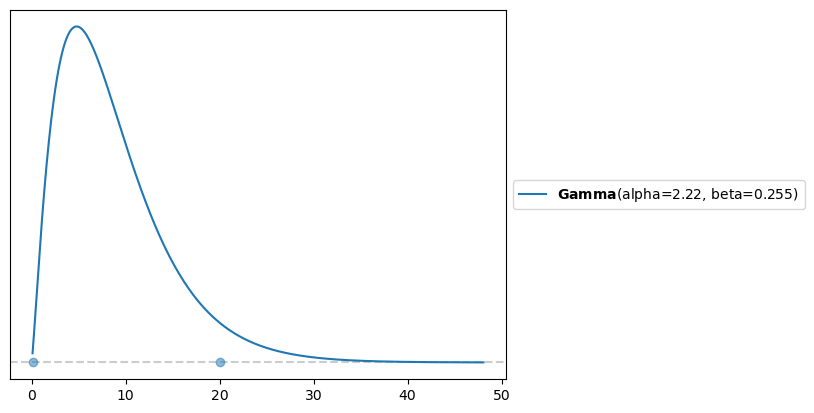

In [8]:
import preliz as pz

gamma_params = pz.maxent(pz.Gamma(), lower=0.1, upper=20, mass=0.95)
gamma_params

In [9]:
gamma_samples = pm.draw(pm.Gamma.dist(alpha=2, beta=0.2), 1000)
fig = px.histogram(x=gamma_samples, nbins=20, title="Gamma Distribution Samples")
fig.show()

In [10]:
t = df_country.select("days_since_100").to_numpy().flatten()
confirmed = df_country.select("confirmed").to_numpy().flatten()

with pm.Model() as model_exp2:
    # Intercept
    a = pm.Normal("a", mu=100, sigma=25)

    # Slope
    b = pm.Normal("b", mu=0.3, sigma=0.1)

    # Exponential regression
    growth = a * (1 + b) ** t

    alpha = pz.maxent(pz.Gamma(), lower=0.1, upper=20, mass=0.95, plot=False).to_pymc("alpha")

    # Likelihood
    pm.NegativeBinomial("obs", growth, alpha=alpha, observed=confirmed)

In [11]:
with model_exp2:
    prior_pred = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

prior_obs = prior_pred.prior_predictive["obs"].values.squeeze().T

fig = go.Figure()
for i in range(min(100, prior_obs.shape[1])):  # Show max 100 traces
    fig.add_trace(
        go.Scatter(
            x=list(range(len(prior_obs[:, i]))),
            y=prior_obs[:, i],
            mode="lines",
            line=dict(color="steelblue", width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.update_layout(
    title="Prior predictive",
    xaxis_title="Days since 100 cases",
    yaxis_title="Positive cases",
    yaxis=dict(range=[-100, 1000]),
    xaxis=dict(range=[0, 10]),
)
fig.show()

Sampling: [a, alpha, b, obs]


In [12]:
with model_exp2:
    trace_exp2 = pm.sample(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


That looks much better. However, we can include even more prior information. For example, we know that the intercept *can not* be below 100 because of how we sliced the data. We can thus create a prior that does not have probability mass below 100. For this, we use the PyMC `HalfNormal` distribution; we can apply the same for the slope which we know is not going to be negative.

In [13]:
t = df_country.select("days_since_100").to_numpy().flatten()
confirmed = df_country.select("confirmed").to_numpy().flatten()

with pm.Model() as model_exp3:
    # Intercept
    a0 = pm.HalfNormal("a0", sigma=25)
    a = pm.Deterministic("a", a0 + 100)

    # Slope
    b = pm.HalfNormal("b", sigma=0.2)

    # Exponential regression
    growth = a * (1 + b) ** t

    gamma_params = pm.find_constrained_prior(
        pm.Gamma, lower=0.1, upper=20, init_guess={"alpha": 6, "beta": 1}, mass=0.95
    )
    alpha = pm.Gamma("alpha", **gamma_params)

    # Likelihood
    pm.NegativeBinomial("obs", growth, alpha=alpha, observed=confirmed)

    prior_pred = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [a0, alpha, b, obs]


In [14]:
fig = px.histogram(x=prior_pred.prior["a"].values.flatten(), title="Prior of a")
fig.show()

In [15]:
fig = px.histogram(x=prior_pred.prior["b"].values.flatten(), title="Prior of b")
fig.show()

In [16]:
obs_samples = az.extract(prior_pred.prior_predictive)["obs"].values

fig = go.Figure()
for i in range(min(100, obs_samples.shape[1])):  # Show max 100 traces
    fig.add_trace(
        go.Scatter(
            x=list(range(len(obs_samples[:, i]))),
            y=obs_samples[:, i],
            mode="lines",
            line=dict(color="steelblue", width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.update_layout(
    title="Prior predictive",
    xaxis_title="Days since 100 cases",
    yaxis_title="Positive cases",
    yaxis=dict(range=[0, 1000]),
    xaxis=dict(range=[0, 10]),
)
fig.show()

Note that even though the intercept parameter can not be below 100 now, we still see data generated at below hundred. Why? 

## 4. Fit model

In [17]:
with model_exp3:
    # Inference button (TM)
    trace_exp3 = pm.sample(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, alpha]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


## 5. Assess convergence

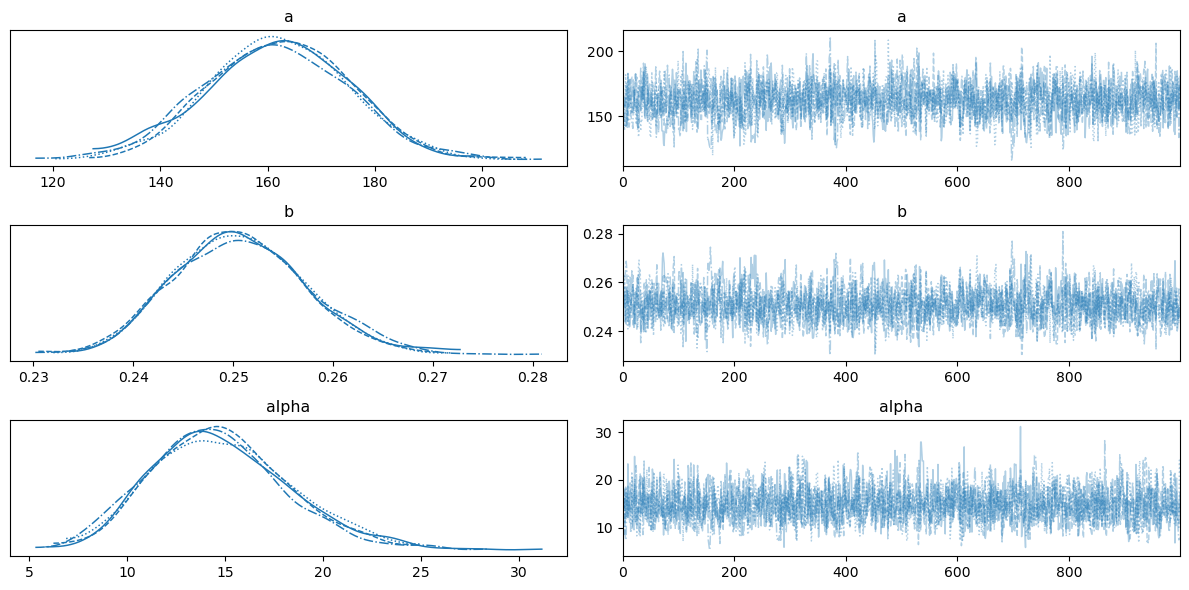

In [18]:
az.plot_trace(trace_exp3, var_names=["a", "b", "alpha"])
import matplotlib.pyplot as plt

plt.tight_layout()
plt.show()

In [19]:
az.summary(trace_exp3, var_names=["a", "b", "alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,162.028,13.169,136.371,185.612,0.329,0.235,1594.0,1379.0,1.0
b,0.251,0.007,0.239,0.264,0.000,0.000,1697.0,1724.0,1.0
alpha,14.790,3.472,8.462,21.338,0.077,0.060,2022.0,2055.0,1.0


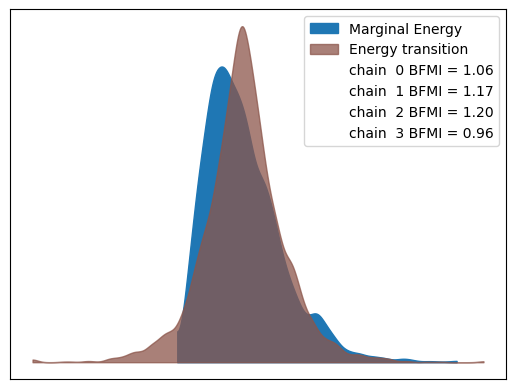

In [20]:
az.plot_energy(trace_exp3)
plt.show()

### Model comparison

Let's quickly compare the two models we were able to sample from.

Model comparison requires the log-likelihoods of the respective models. For efficiency, these are not computed automatically, so we need to manually calculate them.

In [21]:
with model_exp2:
    pm.compute_log_likelihood(trace_exp2)

with model_exp3:
    pm.compute_log_likelihood(trace_exp3)

Output()

Output()

Now we can use the ArviZ `compare` function:

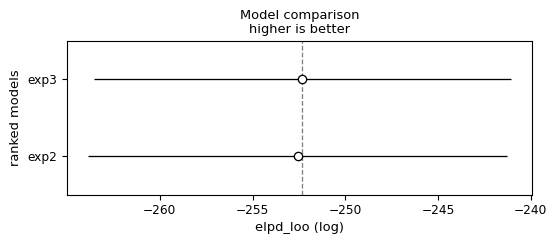

In [22]:
comparison = az.compare({"exp2": trace_exp2, "exp3": trace_exp3})
az.plot_compare(comparison)
plt.show()

It seems like bounding the priors did not result in better fit. This is not unexpected because our change in prior was very small. We will still continue with `model_exp3` because we have prior information that these parameters are bounded in this way.

### 6. Check model fit

Similar to the prior predictive, we can also generate new data by repeatedly taking samples from the posterior and generating data using these parameters. This process is called **posterior predictive checking** and is a crucial step in Bayesian model validation.

Posterior predictive checking works by:
1. Taking parameter samples from the posterior distribution (which we already have from MCMC sampling)
2. For each set of parameter values, generating new synthetic datasets using the same likelihood function as our model
3. Comparing these synthetic datasets to our observed data

This allows us to assess whether our model can reproduce key features of the observed data. If the posterior predictive samples look very different from our actual data, it suggests our model may be missing important aspects of the data-generating process. Conversely, if the posterior predictive samples encompass our observed data well, it provides evidence that our model is capturing the essential patterns in the data.

In [23]:
with model_exp3:
    # Draw sampels from posterior predictive
    post_pred = pm.sample_posterior_predictive(trace_exp3.posterior, random_seed=RANDOM_SEED)

Sampling: [obs]


Output()

In [24]:
post_pred_samples = post_pred.posterior_predictive["obs"].sel(chain=0).values.squeeze().T
confirmed_values = confirmed

fig = go.Figure()

# Add posterior predictive samples
for i in range(min(100, post_pred_samples.shape[1])):  # Show max 100 traces
    fig.add_trace(
        go.Scatter(
            x=list(range(len(post_pred_samples[:, i]))),
            y=post_pred_samples[:, i],
            mode="lines",
            line=dict(color="steelblue", width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

# Add actual data
fig.add_trace(
    go.Scatter(
        x=list(range(len(confirmed_values))),
        y=confirmed_values,
        mode="lines+markers",
        line=dict(color="red", width=2),
        name="Data",
    )
)

fig.update_layout(
    title=country,
    xaxis_title="Days since 100 cases",
    yaxis_title="Confirmed cases (log scale)",
    yaxis_type="log",
)
fig.show()

OK, that does not look terrible; the data essentially behaves like a random draw from the model.

As an additional check, we can also inspect the model residuals.

In [25]:
resid = post_pred.posterior_predictive["obs"].sel(chain=0) - confirmed_values
resid_values = resid.values.T

fig = go.Figure()

for i in range(min(100, resid_values.shape[1])):  # Show max 100 traces
    fig.add_trace(
        go.Scatter(
            x=list(range(len(resid_values[:, i]))),
            y=resid_values[:, i],
            mode="lines",
            line=dict(color="steelblue", width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.update_layout(
    title="Residuals",
    xaxis_title="Days since 100 cases",
    yaxis_title="Residual",
    yaxis=dict(range=[-50000, 200000]),
)
fig.show()

What can you see?

### Prediction and forecasting

We are often interested in predicting or forecasting. In PyMC, you can do so easily using `pm.Data` nodes, which provide a powerful mechanism for out-of-sample prediction and forecasting.

Wrapping your input data in `pm.Data` allows you to define data containers within a PyMC model that can be dynamically updated after model fitting. This is particularly useful for prediction scenarios where you want to:

1. **Train on observed data**: Fit your model using the available training data
2. **Switch to prediction inputs**: Replace the training data with new input values (e.g., future time points)
3. **Generate predictions**: Use posterior predictive sampling to generate forecasts based on the fitted model

Let's demonstrate this approach by modifying our exponential growth model to use `pm.Data` nodes.

In [26]:
with pm.Model() as model_exp4:
    # pm.Data needs to be in the model context so that we can
    # keep track of it.
    # Then, we can then use it like any other array.
    t_data = pm.Data("t", df_country.select("days_since_100").to_numpy().flatten())
    confirmed_data = pm.Data("confirmed", df_country.select("confirmed").to_numpy().flatten())

    # Intercept
    a0 = pm.HalfNormal("a0", sigma=25)
    a = pm.Deterministic("a", a0 + 100)

    # Slope
    b = pm.HalfNormal("b", sigma=0.2)

    # Exponential regression
    growth = a * (1 + b) ** t_data

    # Likelihood
    pm.NegativeBinomial(
        "obs", growth, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=confirmed_data
    )

    trace_exp4 = pm.sample(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, alpha]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [27]:
with model_exp4:
    # Update our data containers.
    # Recall that because confirmed is observed, we do not
    # need to specify any data, as that is only needed
    # during inference. But do have to update it to match
    # the shape.
    pm.set_data({"t": np.arange(60), "confirmed": np.zeros(60, dtype="int")})

    post_pred = pm.sample_posterior_predictive(trace_exp4.posterior, random_seed=RANDOM_SEED)

Sampling: [obs]


Output()

As we held data back before, we can now see how the predictions of the model

In [28]:
post_pred_samples = post_pred.posterior_predictive["obs"].sel(chain=0).squeeze().values.T
in_sample_confirmed = df_country.select("confirmed").to_numpy().flatten()

# Get out-of-sample data
df_confirmed = (
    df.filter(pl.col("country") == country)
    .filter(pl.col("date") <= date)
    .select("confirmed")
    .to_numpy()
    .flatten()
)

fig = go.Figure()

# Add posterior predictive samples
for i in range(min(100, post_pred_samples.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(post_pred_samples[:, i]))),
            y=post_pred_samples[:, i],
            mode="lines",
            line=dict(color="steelblue", width=0.5),
            opacity=0.2,
            showlegend=False,
        )
    )

# Add in-sample data
fig.add_trace(
    go.Scatter(
        x=list(range(len(in_sample_confirmed))),
        y=in_sample_confirmed,
        mode="lines+markers",
        line=dict(color="red", width=2),
        name="in-sample",
    )
)

# Add out-of-sample data
if len(df_confirmed) > 29:
    fig.add_trace(
        go.Scatter(
            x=list(range(29, len(df_confirmed))),
            y=df_confirmed[29:],
            mode="lines+markers",
            line=dict(color="blue", width=2),
            name="out-of-sample",
        )
    )

fig.update_layout(
    title=country,
    xaxis_title="Days since 100 cases",
    yaxis_title="Confirmed cases",
    yaxis_type="log",
)
fig.show()

## 7. Improve model

### Logistic model

<img src="https://s3-us-west-2.amazonaws.com/courses-images-archive-read-only/wp-content/uploads/sites/924/2015/11/25202016/CNX_Precalc_Figure_04_07_0062.jpg"/>

In [29]:
df_country = df.filter(pl.col("country") == country).filter(pl.col("date") <= date)

with pm.Model() as logistic_model:
    t_data = pm.Data("t", df_country.select("days_since_100").to_numpy().flatten())
    confirmed_data = pm.Data("confirmed", df_country.select("confirmed").to_numpy().flatten())

    # Intercept
    a0 = pm.HalfNormal("a0", sigma=25)
    intercept = pm.Deterministic("intercept", a0 + 100)

    # Slope
    b = pm.HalfNormal("b", sigma=0.2)

    carrying_capacity = pm.Uniform("carrying_capacity", lower=1_000, upper=80_000_000)
    # Transform carrying_capacity to a
    a = carrying_capacity / intercept - 1

    # Logistic
    growth = carrying_capacity / (1 + a * pm.math.exp(-b * t_data))

    # Likelihood
    pm.NegativeBinomial(
        "obs", growth, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=confirmed_data
    )

    prior_pred = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [a0, alpha, b, carrying_capacity, obs]


In [30]:
prior_obs = prior_pred.prior_predictive["obs"].squeeze().values.T

fig = go.Figure()
for i in range(min(100, prior_obs.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(prior_obs[:, i]))),
            y=prior_obs[:, i],
            mode="lines",
            line=dict(color="steelblue", width=0.5),
            opacity=0.4,
            showlegend=False,
        )
    )

fig.update_layout(
    title="Prior predictive",
    xaxis_title="Days since 100 cases",
    yaxis_title="Positive cases",
    yaxis_type="log",
)
fig.show()

In [31]:
with logistic_model:
    # Inference
    trace_logistic = pm.sample(**sampler_kwargs, target_accept=0.9)

    # Sample posterior predcitive
    pm.sample_posterior_predictive(trace_logistic, extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, carrying_capacity, alpha]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.
Sampling: [obs]


Output()

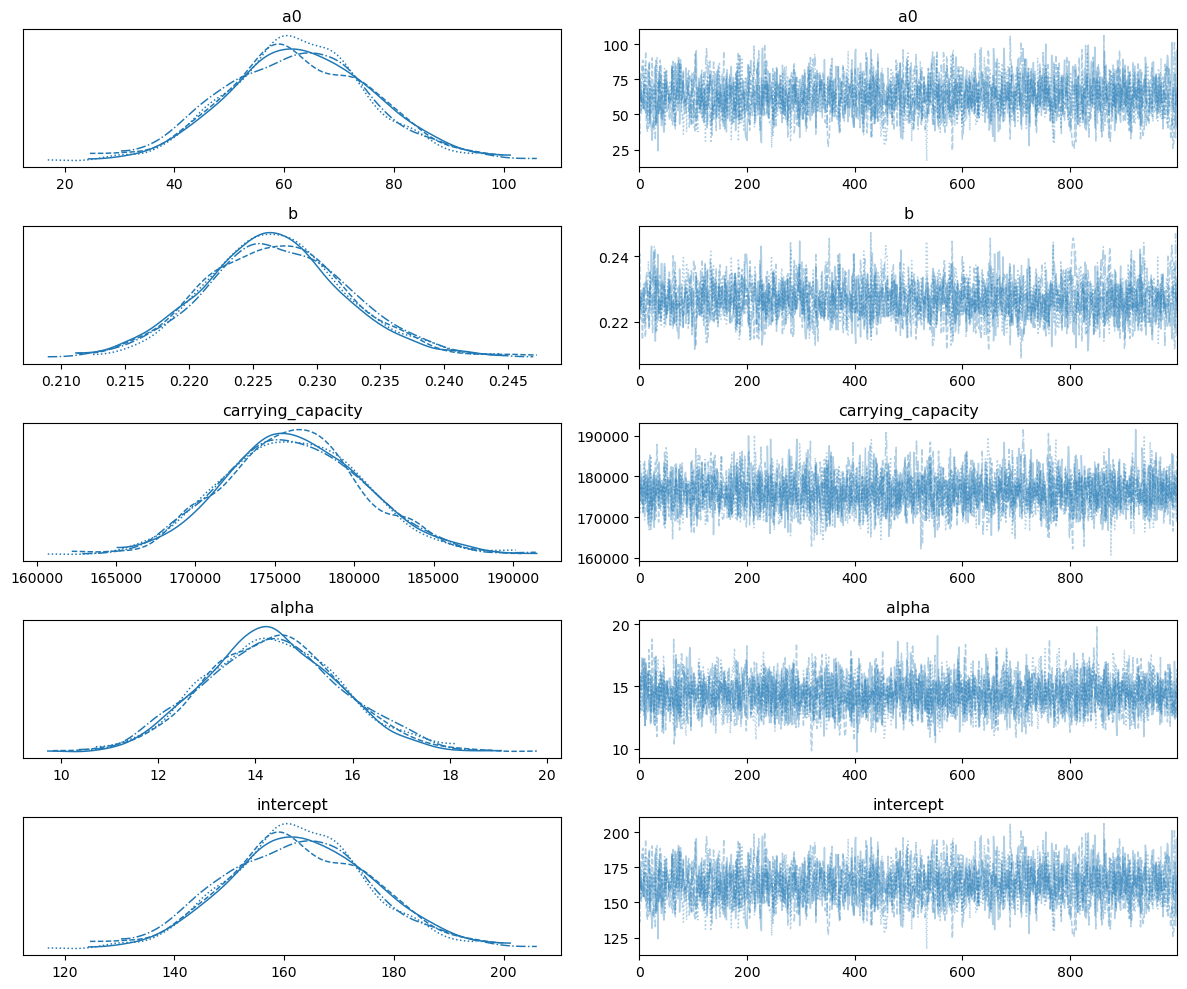

In [32]:
az.plot_trace(trace_logistic)
plt.tight_layout()
plt.show()

In [33]:
df_confirmed = (
    df.filter(pl.col("country") == country)
    .filter(pl.col("date") <= date)
    .select("confirmed")
    .to_numpy()
    .flatten()
)
post_pred_samples = trace_logistic.posterior_predictive["obs"].sel(chain=0).squeeze().values.T

fig = go.Figure()

# Add posterior predictive samples
for i in range(min(100, post_pred_samples.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(post_pred_samples[:, i]))),
            y=post_pred_samples[:, i],
            mode="lines",
            line=dict(color="steelblue", width=0.5),
            opacity=0.2,
            showlegend=False,
        )
    )

# Add actual data
fig.add_trace(
    go.Scatter(
        x=list(range(len(df_confirmed))),
        y=df_confirmed,
        mode="lines+markers",
        line=dict(color="red", width=2),
        name="Data",
    )
)

fig.update_layout(title=country, xaxis_title="Days since 100 cases", yaxis_title="Confirmed cases")
fig.show()

In [34]:
resid = trace_logistic.posterior_predictive["obs"].sel(chain=0).squeeze().values - df_confirmed
resid_values = resid.T

fig = go.Figure()

for i in range(min(100, resid_values.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(resid_values[:, i]))),
            y=resid_values[:, i],
            mode="lines",
            line=dict(color="steelblue", width=0.5),
            opacity=0.2,
            showlegend=False,
        )
    )

fig.update_layout(title="Residuals", xaxis_title="Days since 100 cases", yaxis_title="Residual")
fig.show()

What is the difference between the residuals from before?

#### Model comparison

In order to compare our models we first need to refit with the longer data we now have. Fortunately we can easily swap out the data because these are `pm.Data` now.

In [35]:
with model_exp4:
    pm.set_data(
        {
            "t": df_country.select("days_since_100").to_numpy().flatten(),
            "confirmed": df_country.select("confirmed").to_numpy().flatten(),
        }
    )

    trace_exp4_full = pm.sample(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, alpha]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


Output()

Output()

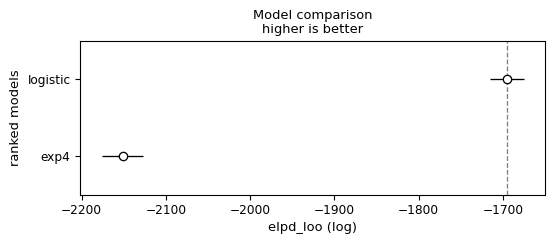

In [36]:
with model_exp4:
    pm.compute_log_likelihood(trace_exp4_full)

with logistic_model:
    pm.compute_log_likelihood(trace_logistic)

az.plot_compare(az.compare({"exp4": trace_exp4_full, "logistic": trace_logistic}))
plt.show()

As you can see, the logistic model provides a much better fit to the data. 

Although there is still some small bias in the residuals but overall we might think our model is quite good. Let's see how it does on a different country.

In [37]:
country = "US"
df_country = df.filter(pl.col("country") == country).filter(pl.col("date") <= date)
df_confirmed = df_country.select("confirmed")

fig = px.line(
    df_country.to_pandas(),
    x="days_since_100",
    y="confirmed",
    title=f"{country} - COVID-19 Cases",
    labels={"days_since_100": "Days since 100 cases", "confirmed": "Confirmed cases"},
)
fig.show()

As you can see, the data looks quite different. Let's see how our logistic model fits this.

In [38]:
df_confirmed = (
    df.filter(pl.col("country") == country).filter(pl.col("date") <= date).select("confirmed")
)

with pm.Model() as logistic_model:
    t_data = pm.Data("t", df_country.select("days_since_100").to_numpy().flatten())
    confirmed_data = pm.Data("confirmed", df_country.select("confirmed").to_numpy().flatten())

    # Intercept
    a0 = pm.HalfNormal("a0", sigma=25)
    intercept = pm.Deterministic("intercept", a0 + 100)

    # Slope
    b = pm.HalfNormal("b", sigma=0.2)

    carrying_capacity = pm.Uniform("carrying_capacity", lower=1_000, upper=100_000_000)
    # Transform carrying_capacity to a
    a = carrying_capacity / intercept - 1

    # Logistic
    growth = carrying_capacity / (1 + a * pm.math.exp(-b * t_data))

    # Likelihood
    pm.NegativeBinomial(
        "obs", growth, alpha=pm.Gamma("alpha", mu=6, sigma=1), observed=confirmed_data
    )

In [39]:
with logistic_model:
    trace_logistic_us = pm.sample(**sampler_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a0, b, carrying_capacity, alpha]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 2 seconds.


Already we see some problems with sampling which should make us suspicious that this model might not be the best for this data.

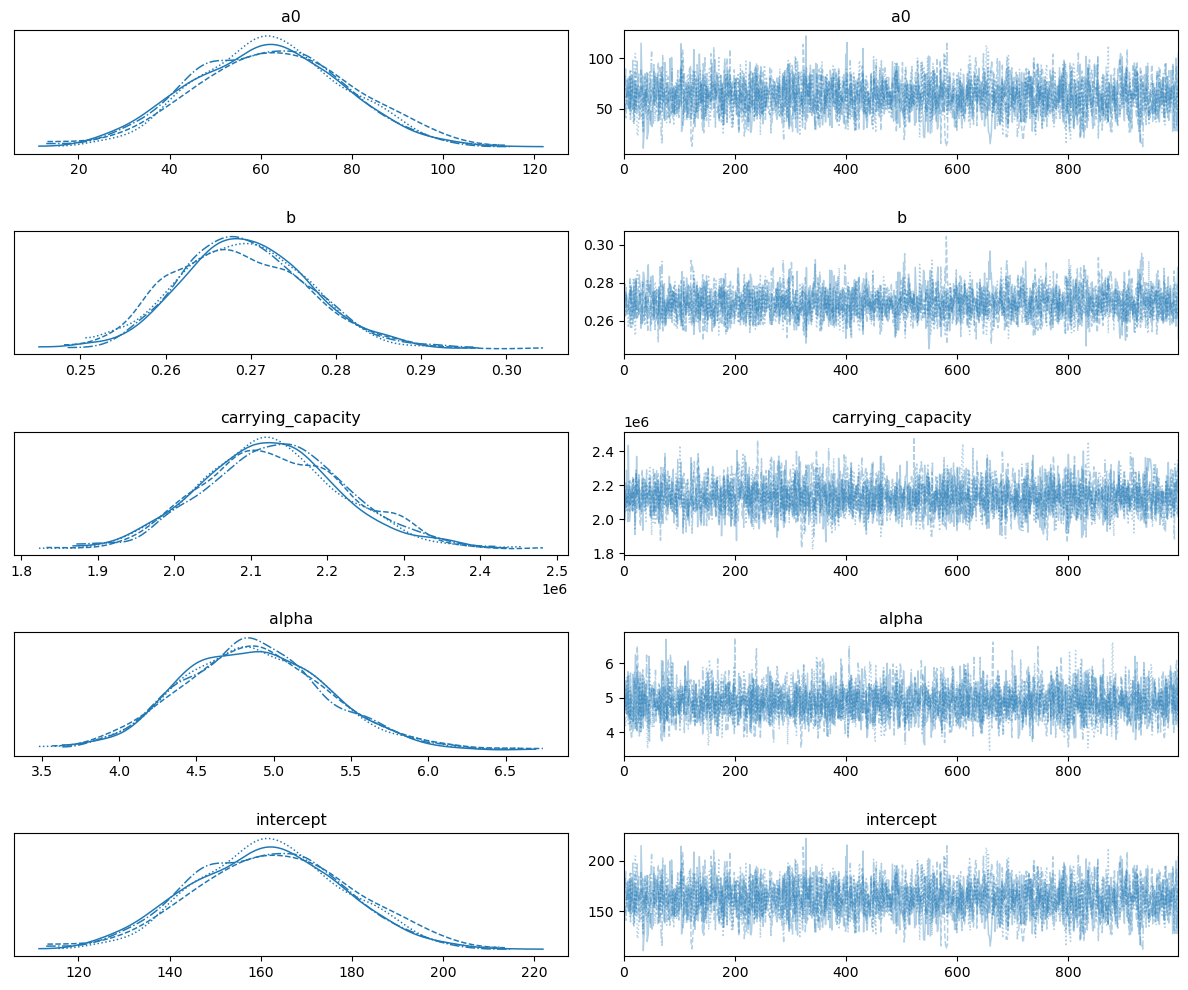

In [40]:
az.plot_trace(trace_logistic_us)
plt.tight_layout()
plt.show()

In [41]:
with logistic_model:
    pm.sample_posterior_predictive(
        trace_logistic_us, extend_inferencedata=True, random_seed=RANDOM_SEED
    )

Sampling: [obs]


Output()

In [42]:
df_confirmed_values = df_confirmed.to_numpy().flatten()
post_pred_samples = trace_logistic_us.posterior_predictive["obs"].sel(chain=0).squeeze().values.T

fig = go.Figure()

# Add posterior predictive samples
for i in range(min(100, post_pred_samples.shape[1])):
    fig.add_trace(
        go.Scatter(
            x=list(range(len(post_pred_samples[:, i]))),
            y=post_pred_samples[:, i],
            mode="lines",
            line=dict(color="steelblue", width=0.5),
            opacity=0.2,
            showlegend=False,
        )
    )

# Add actual data
fig.add_trace(
    go.Scatter(
        x=list(range(len(df_confirmed_values))),
        y=df_confirmed_values,
        mode="lines+markers",
        line=dict(color="red", width=2),
        name="Data",
    )
)

fig.update_layout(title=country, xaxis_title="Days since 100 cases", yaxis_title="Confirmed cases")
fig.show()

As you can see, the model is not a great fit to this data. Why? What assumptions does the model make about the spread of COVID-19?

## References

Gelman, A., Vehtari, A., Simpson, D., Margossian, C. C., Carpenter, B., Yao, Y., ... & Modrák, M. (2020). Bayesian workflow. *arXiv preprint arXiv:2011.01808*.

## Authors
- Originally authored by Thomas Wiecki in 2020
- Adapted and expanded by Chris Fonnesbeck in June 2025 

## Watermark

In [43]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Jun 17 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.3.0

polars    : 1.30.0
preliz    : 0.19.0
numpy     : 1.26.4
matplotlib: 3.10.3
arviz     : 0.21.0
pymc      : 5.23.0
plotly    : 6.1.2

Watermark: 2.5.0



:::{include} ../page_footer.md
:::